In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('data/pacific.csv')

In [18]:
df.replace(-999, np.nan, inplace=True)

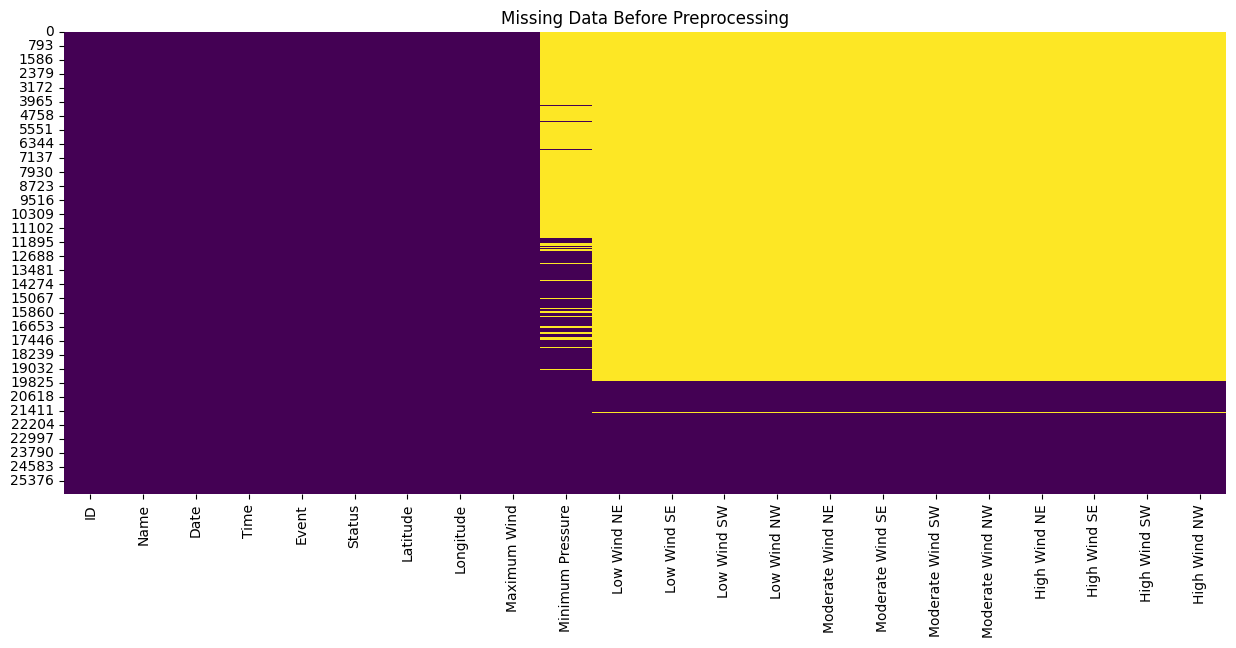

In [19]:
# Visualize missing values
plt.figure(figsize=(15, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Before Preprocessing')
plt.show()

In [20]:
def convert_lat_long(val):
    # removes the direction (n/s/e/w) and converts to float, negates if south or west
    direction = val[-1]
    val = float(val[:-1])
    if direction in ['S', 'W']:
        val *= -1
    return val

In [21]:
df['Latitude'] = df['Latitude'].apply(convert_lat_long)
df['Longitude'] = df['Longitude'].apply(convert_lat_long)
df['Next_Latitude'] = df['Next_Latitude'].apply(convert_lat_long)
df['Next_Longitude'] = df['Next_Longitude'].apply(convert_lat_long)

KeyError: 'Next_Latitude'

In [ ]:
# parsing dates and times to combine into a datetime column
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df['Time'] = df['Time'].apply(lambda x: "{:04d}".format(x))  # pads to be 4 digits
df['Time'] = pd.to_timedelta(df['Time'].str[:2] + ':' + df['Time'].str[2:] + ':00')  # converts to timedelta (duration / diff between 2 dates/tiems)
df['DateTime'] = df['Date'] + df['Time']
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
# ensure numeric columns are of the correct data type
numeric_cols = ['Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
print(df.head(), df.size)

         ID                 Name Event Status  Latitude  Longitude  \
0  AL011851              UNNAMED           HU      28.0      -94.8   
1  AL011851              UNNAMED           HU      28.0      -95.4   
2  AL011851              UNNAMED           HU      28.0      -96.0   
3  AL011851              UNNAMED           HU      28.1      -96.5   
4  AL011851              UNNAMED     L     HU      28.2      -96.8   

   Maximum Wind  Minimum Pressure  Low Wind NE  Low Wind SE  ...  Low Wind NW  \
0            80               NaN          NaN          NaN  ...          NaN   
1            80               NaN          NaN          NaN  ...          NaN   
2            80               NaN          NaN          NaN  ...          NaN   
3            80               NaN          NaN          NaN  ...          NaN   
4            80               NaN          NaN          NaN  ...          NaN   

   Moderate Wind NE  Moderate Wind SE  Moderate Wind SW  Moderate Wind NW  \
0              

In [ ]:
missing_data_threshold = 0.2  # 20% threshold for removal
imputation_threshold = 0.8   # 80% threshold for imputation

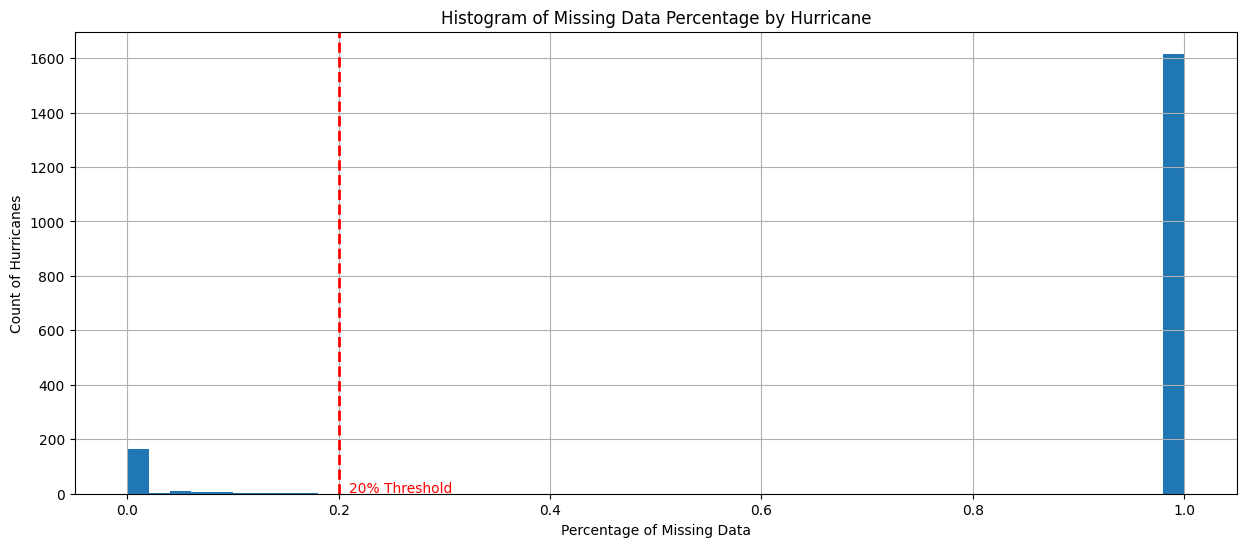

In [ ]:
# Calculate the percentage of missing values for each hurricane (ID)
missing_percentage_by_id = df.isnull().groupby(df['ID']).mean().max(axis=1)

# Plot the distribution of missing data by hurricane
plt.figure(figsize=(15, 6))
missing_percentage_by_id.hist(bins=50)
plt.title('Histogram of Missing Data Percentage by Hurricane')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count of Hurricanes')
plt.axvline(x=missing_data_threshold, color='red', linestyle='dashed', linewidth=2)
plt.text(missing_data_threshold+0.01, 5, '20% Threshold', rotation=0, color='red')
plt.show()

In [ ]:
# Calculate the percentage of missing values for each hurricane (ID)
missing_percentage_by_id = df.isnull().groupby(df['ID']).mean().max(axis=1)

# Find IDs with missing data above the threshold
ids_to_remove = missing_percentage_by_id[missing_percentage_by_id > missing_data_threshold].index

# Remove those IDs from the DataFrame
df_cleaned = df[~df['ID'].isin(ids_to_remove)].copy()

# Now, for the remaining data, impute missing values where the missing data is below the threshold
# Define a function to impute missing values for a column
def impute_missing(df, column):
    # Calculate the mean for the column, ignoring NaN values
    mean_value = df[column].mean()
    
    # Only impute if the percentage of NaN is below the threshold
    if df[column].isnull().mean() < missing_data_threshold:
        df_cleaned[column].fillna(mean_value, inplace=True)

# Apply the imputation function to each numeric column
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    impute_missing(df, col)

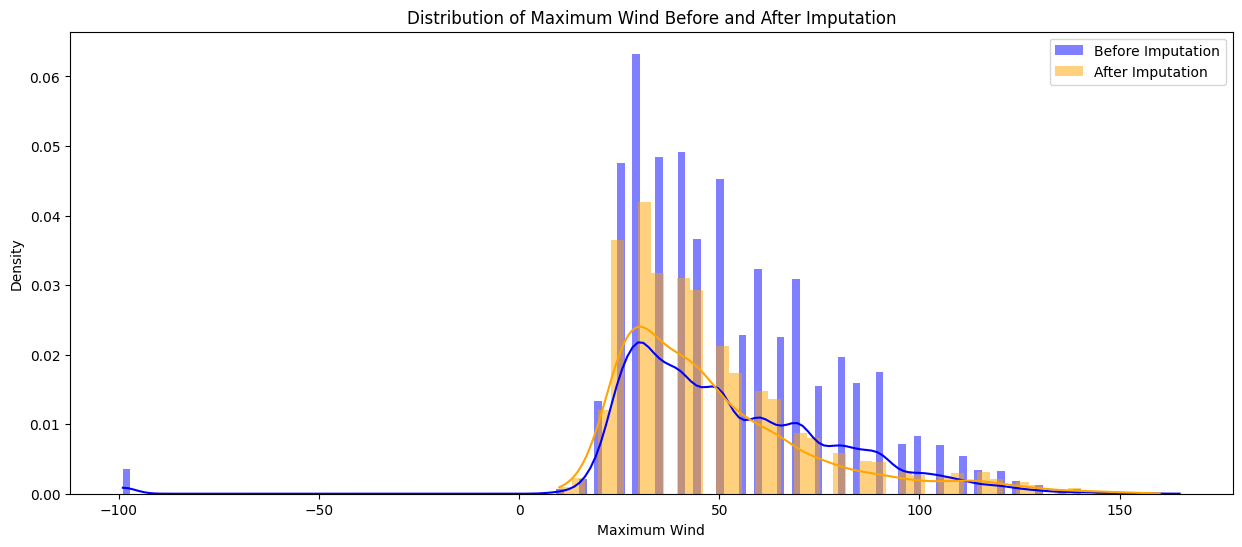

In [ ]:
# Example for 'Maximum Wind' column
plt.figure(figsize=(15, 6))
sns.histplot(df['Maximum Wind'], kde=True, stat="density", linewidth=0, color='blue', label='Before Imputation')
sns.histplot(df_cleaned['Maximum Wind'], kde=True, stat="density", linewidth=0, color='orange', label='After Imputation')
plt.title('Distribution of Maximum Wind Before and After Imputation')
plt.legend()
plt.show()

In [ ]:
print(df.head(), df.size)

         ID                 Name Event Status  Latitude  Longitude  \
0  AL011851              UNNAMED           HU      28.0      -94.8   
1  AL011851              UNNAMED           HU      28.0      -95.4   
2  AL011851              UNNAMED           HU      28.0      -96.0   
3  AL011851              UNNAMED           HU      28.1      -96.5   
4  AL011851              UNNAMED     L     HU      28.2      -96.8   

   Maximum Wind  Minimum Pressure  Low Wind NE  Low Wind SE  ...  Low Wind NW  \
0            80               NaN          NaN          NaN  ...          NaN   
1            80               NaN          NaN          NaN  ...          NaN   
2            80               NaN          NaN          NaN  ...          NaN   
3            80               NaN          NaN          NaN  ...          NaN   
4            80               NaN          NaN          NaN  ...          NaN   

   Moderate Wind NE  Moderate Wind SE  Moderate Wind SW  Moderate Wind NW  \
0              

In [22]:
df.to_csv('data/pacific_cleaned.csv', index=False)